# Official notebook to detect anomaly using marginal likelihood and LOF

## Preambles

Loading and previewing some data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

In [3]:
np.random.seed(6969)

In [4]:
df = pd.read_csv('kalmaned2.csv')

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,...,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Vehicle_EKF_Accel,Vehicle_EKF_Theta,Vehicle_EKF_Velocity
0,0,0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,...,19.89,0.00,5,0,0,0.0,0.0,0.352090,-0.000532,18.144384
1,1,1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,...,19.89,0.00,5,0,0,0.0,0.0,0.606310,-0.000481,18.179593
2,2,2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,...,19.89,0.00,5,0,0,0.0,0.0,0.662968,0.000942,18.265646
3,3,3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,...,19.89,0.00,5,0,0,0.0,0.0,0.299653,0.001631,18.312187
4,4,4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,...,19.89,1.07,5,0,0,0.0,0.0,0.289715,0.000712,18.325577


<AxesSubplot: >

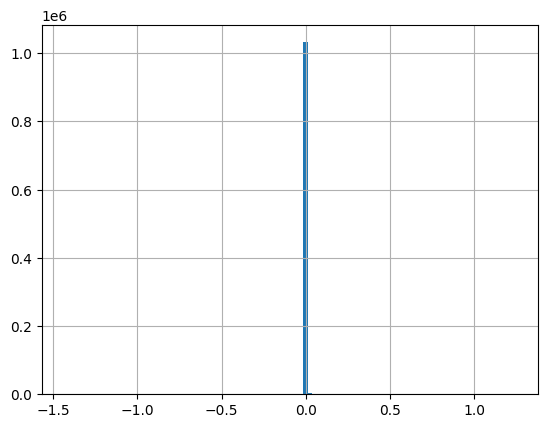

In [6]:
df['Vehicle_EKF_Theta'].hist(bins=100)

## Determining the road patch boundaries 

By plotting the histogram and the max, min of the vehicle coordinates

In [7]:
df['Local_X'].min()

0.879

In [8]:
df['Local_X'].max()

73.318

<AxesSubplot: >

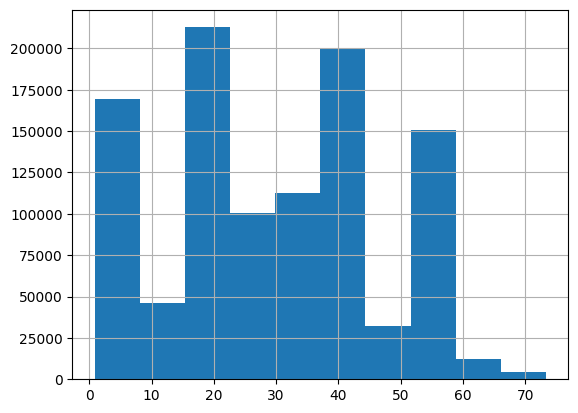

In [9]:
df['Local_X'].hist()

We see that the X of vehicles range from 0 to approximately 75ft.

<AxesSubplot: >

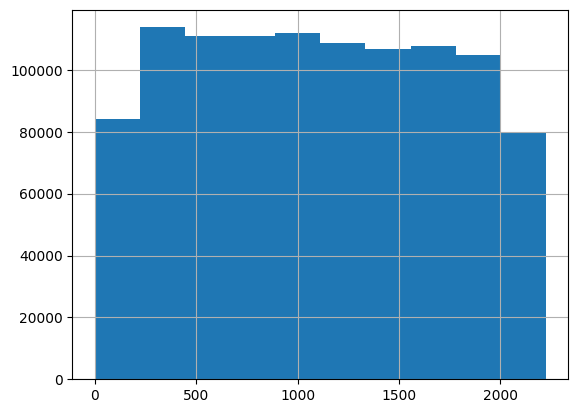

In [10]:
df['Local_Y'].hist()

In [11]:
df['Local_Y'].min()

0.0

In [12]:
df['Local_Y'].max()

2224.58

Similarly, for the Y coordinates, ranging from 0 to 2224.58ft.

## Generate a bunch of random trajectories inside the road patch

In [13]:
import pandas as pd
from ngsim_processor import NGSIM_Processor as NGSIM

if __name__ == '__main__':
    np.random.seed(6969)
    container_t = []
    container_x = []
    container_y = []
    num_of_trajs = 200
    traj_length = []

    df = pd.read_csv('kalmaned2.csv')
    ngsim = NGSIM(df)
    ngsim.set_patch(0.0, 75.0, 500.0, 1050.0) # see the notebook df_stats.py to see where these numbers come from

    for i in range(num_of_trajs):
        t, x, y = ngsim.get_trajectory_random_in_patch()
        container_t.append(t)
        container_x.append(x)
        container_y.append(y)
        traj_length.append(len(t))
        if i%50 == 0:
            print('Trajectory {:d} generated, length {:d}'.format(i, len(t)))

    print('Process completed')


# See PyCharm help at https://www.jetbrains.com/help/pycharm/

NGSIM Processor is initialized
Trajectory 0 generated, length 116
Trajectory 50 generated, length 370
Trajectory 100 generated, length 180
Trajectory 150 generated, length 127
Process completed


This is the distribution of the starting time of the trajectory (so that it can be useful to set the starting gtime of the simulator)

(array([11.,  4.,  9.,  6., 14.,  8., 17., 11.,  5., 14.,  9.,  5., 10.,
        11., 13.,  7., 12., 14.,  7., 13.]),
 array([ 43800.,  76870., 109940., 143010., 176080., 209150., 242220.,
        275290., 308360., 341430., 374500., 407570., 440640., 473710.,
        506780., 539850., 572920., 605990., 639060., 672130., 705200.]),
 <BarContainer object of 20 artists>)

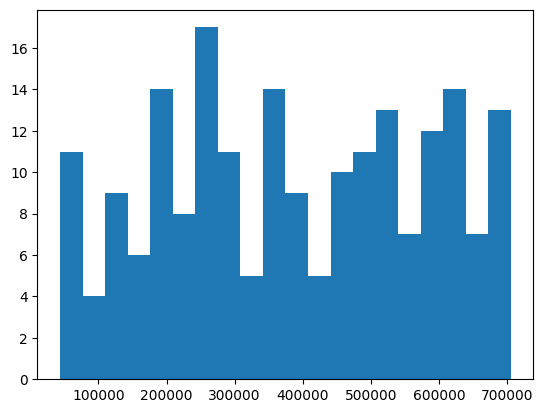

In [14]:
plt.hist(np.array([x[0] - df['Global_Time'].min() for x in container_t]), bins = 20)

Set all entrance time to zero

In [15]:
for i in range(num_of_trajs):
    container_t[i] -= container_t[i][0]
    # container_t[i] -= df['Global_Time'].min()

(array([ 1.,  0.,  1.,  0.,  0.,  3.,  9., 12., 12.,  8.,  9.,  9.,  5.,
         4.,  6.,  5.,  9.,  4.,  6.,  5.,  4.,  2.,  7.,  1.,  4.,  3.,
         0.,  1.,  3.,  4.,  2.,  2.,  2.,  3.,  3.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  2.,  2.,  3.,  0.,  3.,  0.,  1.,  1.,
         1.,  2.,  4.,  0.,  3.,  3.,  3.,  2.,  2.,  0.,  1.,  0.,  0.,
         0.,  3.,  0.,  1.,  3.,  2.,  0.,  0.,  0.,  2.]),
 array([ 83.        ,  88.05333333,  93.10666667,  98.16      ,
        103.21333333, 108.26666667, 113.32      , 118.37333333,
        123.42666667, 128.48      , 133.53333333, 138.58666667,
        143.64      , 148.69333333, 153.74666667, 158.8       ,
        163.85333333, 168.90666667, 173.96      , 179.01333333,
        184.06666667, 189.12      , 194.17333333, 199.22666667,
        204.28      , 209.33333333, 214.38666667, 219.44      ,
        224.49333333, 229.54666667, 234.6       , 239.65333333,
        244.70666667, 249.76      , 254.81333333, 259.86666667,

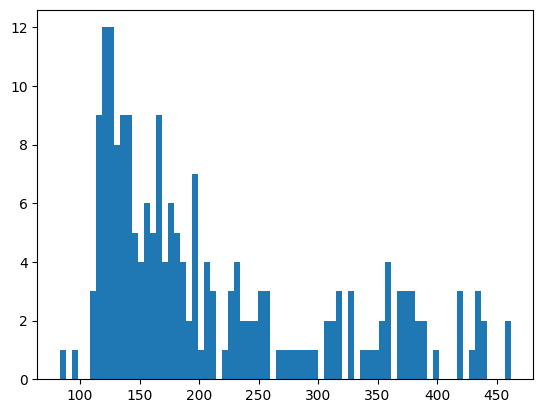

In [16]:
plt.hist(traj_length, bins=75)

From this distribution of trajectory length, it makes sense to extrapolate a little bit of trajectories to timestep 94, while trimming other longer trajectories to 94 timesteps. 

## Trim and lengthen trajectories

First, convert everything to numpy arrays

In [17]:
for i in range(num_of_trajs):
    container_t[i] = np.array(container_t[i])
    container_x[i] = np.array(container_x[i])
    container_y[i] = np.array(container_y[i])

In [18]:
from trim_and_lengthen import lengthen_trajectory_by_spline, trim_trajectory

In [19]:
median_traj_length = 150
new_t_vec = np.arange(0, median_traj_length * 100, 100)
container_x_new = container_x.copy()
container_y_new = container_y.copy()
for i in range(num_of_trajs):
    if traj_length[i] < median_traj_length:
        # Trajectory is shorter than median length, prolong the trajectory
        new_x_vec = lengthen_trajectory_by_spline(container_t[i], container_x[i], new_t_vec)
        new_y_vec = lengthen_trajectory_by_spline(container_t[i], container_y[i], new_t_vec)
        container_x_new[i] = new_x_vec
        container_y_new[i] = new_y_vec
    else:
        # Trajectory is equal or longer than the median length, trim the trajectory
        new_x_vec = trim_trajectory(container_t[i], container_x[i], new_t_vec)
        new_y_vec = trim_trajectory(container_t[i], container_y[i], new_t_vec)
        container_x_new[i] = new_x_vec
        container_y_new[i] = new_y_vec

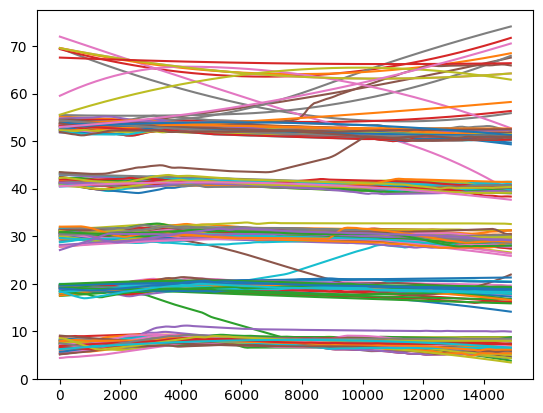

In [20]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_x_new[i])

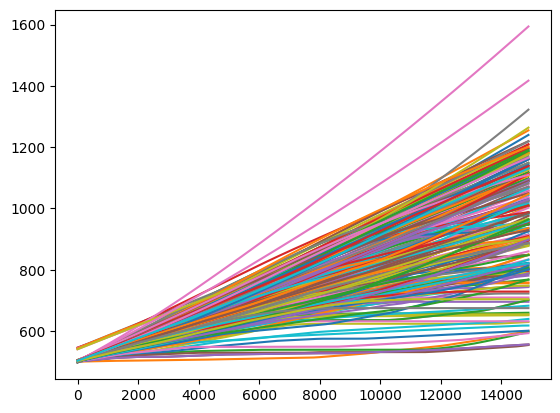

In [21]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_y_new[i])

Starting points of the observed trajectories. Should be close to the patch start at 500ft.

(array([ 3.,  0.,  2.,  7., 20., 37., 31., 34., 30., 19.,  4.,  4.,  1.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  2.]),
 array([497.30666768, 497.91183358, 498.51699948, 499.12216538,
        499.72733128, 500.33249718, 500.93766308, 501.54282898,
        502.14799488, 502.75316078, 503.35832667, 503.96349257,
        504.56865847, 505.17382437, 505.77899027, 506.38415617,
        506.98932207, 507.59448797, 508.19965387, 508.80481977,
        509.40998567, 510.01515157, 510.62031747, 511.22548337,
        511.83064927, 512.43581517, 513.04098107, 513.64614697,
        514.25131287, 514.85647877, 515.46164467, 516.06681057,
        516.67197647, 517.2771

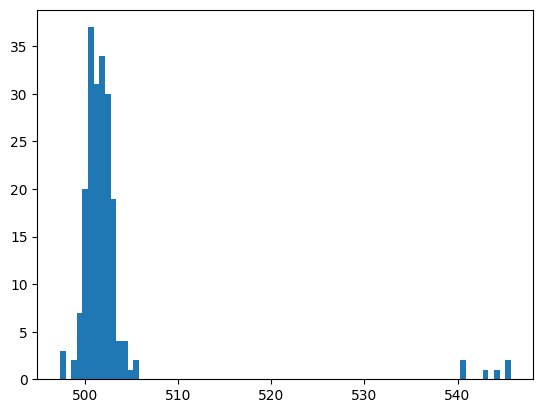

In [22]:
plt.hist(np.array([x[0] for x in container_y_new]), bins=80)

## Offsetting the trajectory starting point to zero

In [23]:
for i in range(num_of_trajs):
    container_y_new[i] = container_y_new[i] - container_y_new[i][0]
    container_x_new[i] = container_x_new[i] - container_x_new[i][0]

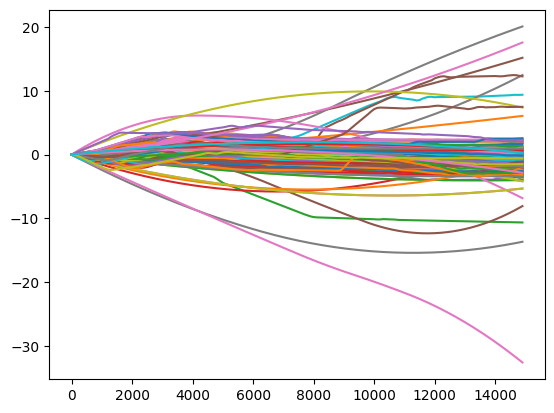

In [24]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_x_new[i])

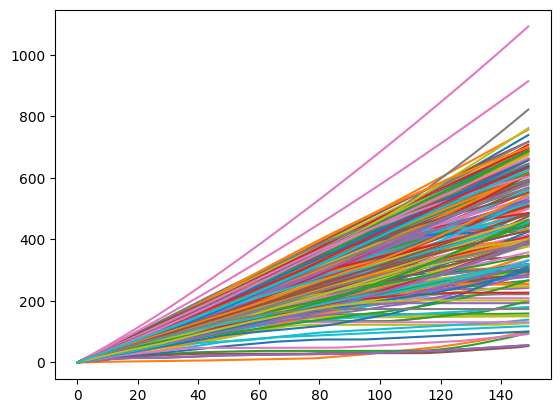

In [25]:
for i in range(num_of_trajs):
    # plt.plot(new_t_vec, container_y_new[i])
    plt.plot(container_y_new[i])

## Save these trajectories into a file

In [26]:
import pickle

file_to_store = open("trajectories.pyo", "wb")
object_to_store = {
    't_vec': new_t_vec,
    'x_vec': container_x_new,
    'y_vec': container_y_new
}

pickle.dump(object_to_store, file_to_store)
file_to_store.close()

# FPCA decomposition and distribution learning

In [27]:
import sklearn
import skfda

In [28]:
fdgrx = skfda.FDataGrid(container_x_new, new_t_vec)
# fdgry = skfda.FDataGrid(container_y_new, new_t_vec)
fdgry = skfda.FDataGrid(container_y_new, np.arange(new_t_vec.shape[0]))

## FPCA decomposition for X component

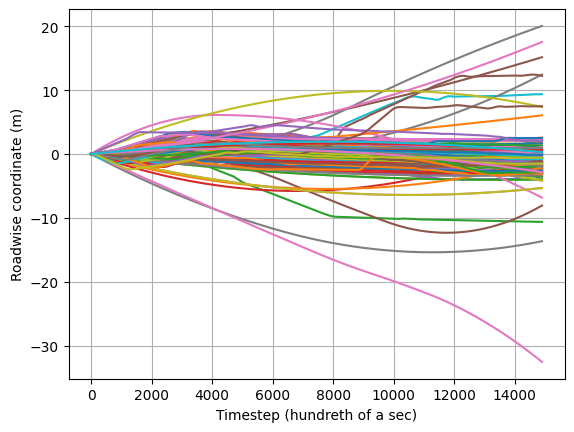

In [29]:
fdgrx.plot()
print('')
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')

In [30]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

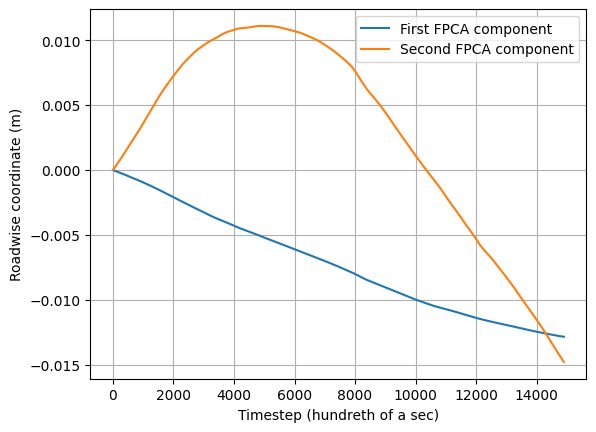

In [31]:
fpca_discretized_rw = FPCA(n_components=2)
fpca_discretized_rw.fit(fdgrx)
fpca_discretized_rw.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

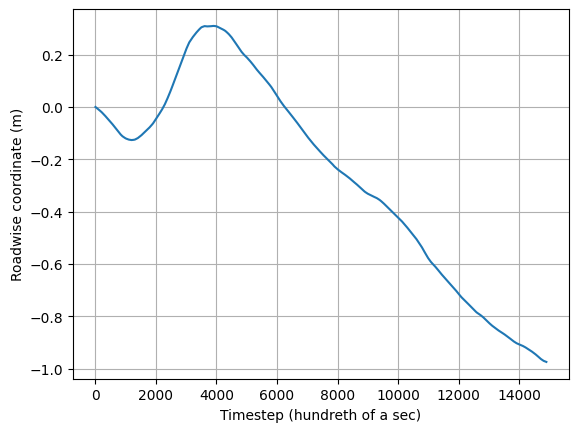

In [32]:
fpca_discretized_rw.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_curve = fpca_discretized_rw.mean_.data_matrix.reshape((-1))

In [33]:
fpca_discretized_rw.explained_variance_ratio_

array([0.88895003, 0.08957913])

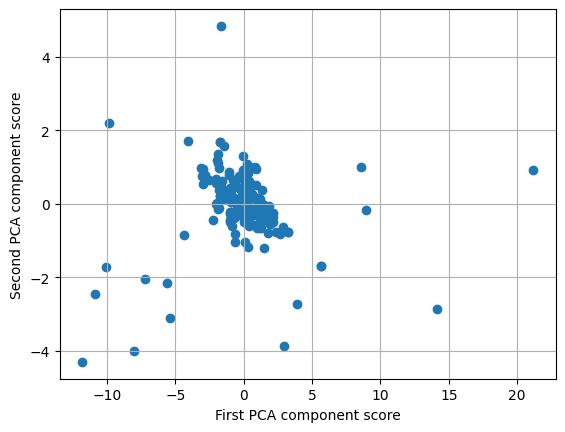

In [34]:
friendly_basis_rw = fpca_discretized_rw.components_.data_matrix.squeeze().transpose()
coeffs_rw = np.matmul(container_x_new - mean_curve, friendly_basis_rw)
plt.scatter(coeffs_rw[:,0], coeffs_rw[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## FPCA with Y component

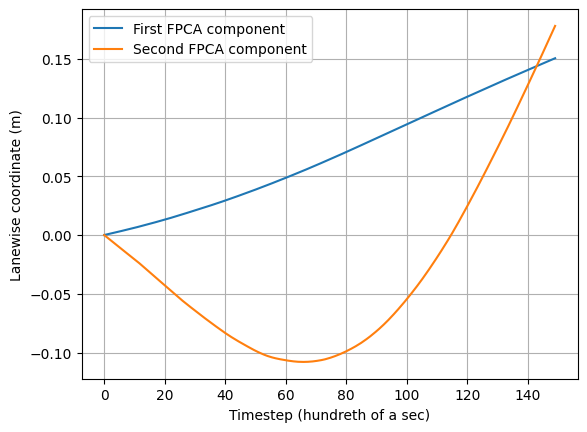

In [35]:
fpca_discretized_rw2 = FPCA(n_components=2)
fpca_discretized_rw2.fit(fdgry)
fpca_discretized_rw2.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

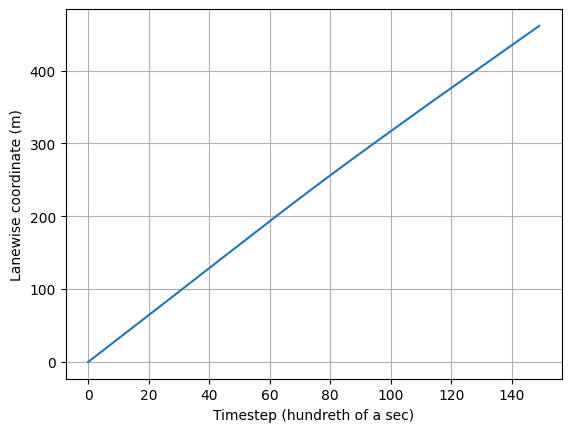

In [36]:
fpca_discretized_rw2.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
print('')
mean_curve2 = fpca_discretized_rw2.mean_.data_matrix.reshape((-1))

In [37]:
fpca_discretized_rw2.explained_variance_ratio_

array([0.9788934 , 0.01931803])

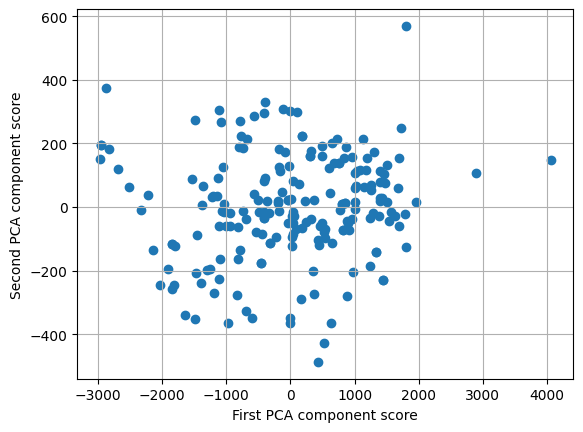

In [38]:
friendly_basis_rw2 = fpca_discretized_rw2.components_.data_matrix.squeeze().transpose()
coeffs_rw2 = np.matmul(container_y_new - mean_curve2, friendly_basis_rw2)
plt.scatter(coeffs_rw2[:,0], coeffs_rw2[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

See how well the two components will approximate the real trajectory, we reconstruct the trajectory from the PCA loads:

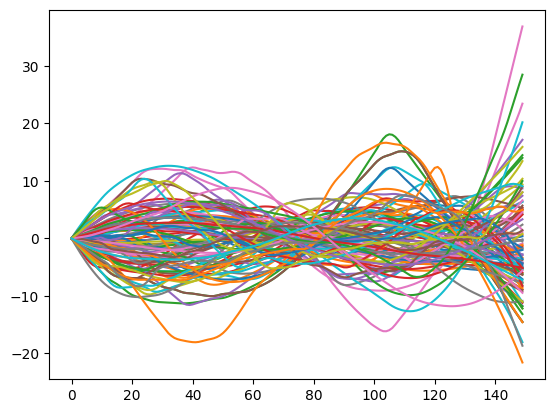

In [39]:
for i in range(100):
    plt.plot(container_y_new[i] - mean_curve2 - (friendly_basis_rw2 @ coeffs_rw2[i].reshape((2,1))).reshape(-1))

The curves show the deviation from reconstruction with actual data that generated the corresponding PCA load.

## Fitting a distribution onto the data

In [40]:
# Plotting helper function

import itertools
from scipy import linalg
import matplotlib as mpl
def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-3.0, 3.0)
    #plt.ylim(-3.0, 3.0)
    #plt.xticks(range(-3, 4))
    #plt.xticks(range(-3, 4))
    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    plt.title(title)

In [41]:
from sklearn.mixture import GaussianMixture

Learning the X functionals (lanewise coordinate) distribution

In [42]:
gm_rw = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw)

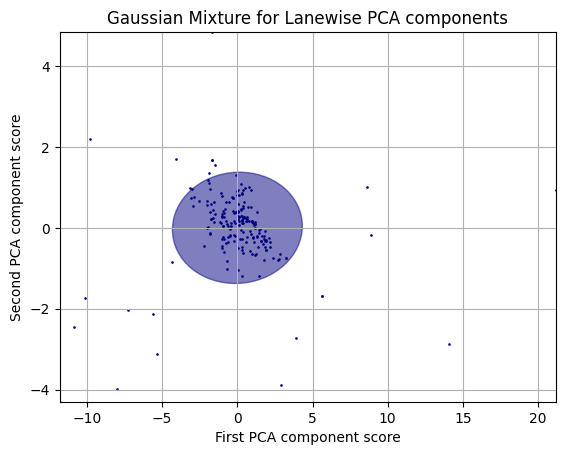

In [43]:
plot_results(coeffs_rw, gm_rw.predict(coeffs_rw), gm_rw.means_, gm_rw.covariances_, 0, 'Gaussian Mixture for Lanewise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

Learning the Y functionals (roadwise coordinate) distribution

In [44]:
gm_rw2 = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw2)

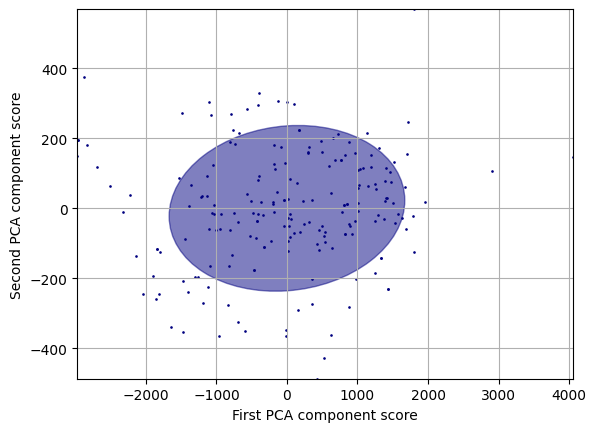

In [45]:
plot_results(coeffs_rw2, gm_rw2.predict(coeffs_rw2), gm_rw2.means_, gm_rw2.covariances_, 0, '')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## Learned parameters

For the X component

In [46]:
gm_rw.means_

array([[7.54951657e-17, 5.55111512e-18]])

In [47]:
gm_rw.covariances_

array([[[9.33294521, 0.09708974],
        [0.09708974, 0.94648071]]])

For the Y component

In [48]:
gm_rw2.means_

array([[4.75210982e-13, 4.04725142e-13]])

In [49]:
gm_rw2.covariances_

array([[[1395330.22542895,   18955.7651573 ],
        [  18955.7651573 ,   28038.13810071]]])

In [50]:
eigvs, _ = np.linalg.eigh(gm_rw2.covariances_)
np.sqrt(eigvs)

array([[ 166.65950626, 1181.35217971]])

Export these gaussian mixture model to a file so that we can load it to our NGSIM simulator

In [51]:
import pickle as pkl

pickle.dump({
    'cov': gm_rw2.covariances_,
    'mu': gm_rw2.means_,
    'mean_curve': mean_curve2,
    'friendly_basis': friendly_basis_rw2
}, open( "y.pkl", "wb" ) )

print('Y component Gaussian Mixture dumped to y.pkl')

pickle.dump({
    'cov': gm_rw.covariances_,
    'mu': gm_rw.means_,
    'mean_curve': mean_curve,
    'friendly_basis': friendly_basis_rw
}, open( "x.pkl", "wb" ) )

print('X component Gaussian Mixture dumped to x.pkl')

Y component Gaussian Mixture dumped to y.pkl
X component Gaussian Mixture dumped to x.pkl


# Decorrelating the PCA load distribution and scaling the eigenvalues for "circular distribution"

To ensure the correctness of the analysis on thresholding, it's wise to convert the ellipse distribution of PCA loads to a circular one (i.e., correlation = 0). We do this by performing PCA.

In [52]:
import scipy

In [53]:
y_pca_loads_covar = gm_rw2.covariances_[0]

In [54]:
y_pca_loads_R = np.linalg.inv(scipy.linalg.sqrtm(scipy.linalg.inv(y_pca_loads_covar)))
y_pca_loads_Q = np.linalg.inv(y_pca_loads_R)

In [55]:
affine_coeffs_rw2 = coeffs_rw2 @ y_pca_loads_Q.T

Text(0, 0.5, 'FPCA 2')

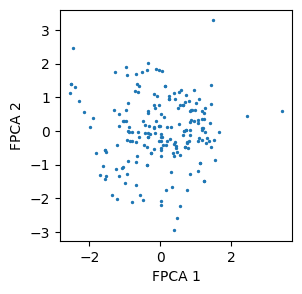

In [56]:
plt.figure(figsize=(3,3))
plt.scatter(affine_coeffs_rw2[:,0], affine_coeffs_rw2[:,1], s=2)
plt.xlabel('FPCA 1')
plt.ylabel('FPCA 2')

# ==========================================
# Generating test curves

In [57]:
test_traj_0 = mean_curve2.copy()

test_traj_1 = coeffs_rw[3,:] @ friendly_basis_rw2.T + mean_curve2 # normal trajectory
test_traj_2 = (coeffs_rw[3,:] + np.array([4000, 1000])) @ friendly_basis_rw2.T + mean_curve2 # speeding vehicles

test_traj_3 = test_traj_1.copy()
test_traj_3[40:] = test_traj_3[40] # stopped vehicles (at 40th timestep)

test_traj_4 = -test_traj_1.copy() # vehicles going in the opposite direction


In [58]:
test_traj_set = np.concatenate((test_traj_0.reshape((1,-1)), test_traj_1.reshape((1,-1)), test_traj_2.reshape((1,-1)), test_traj_3.reshape((1,-1)), test_traj_4.reshape((1,-1))), axis=0)

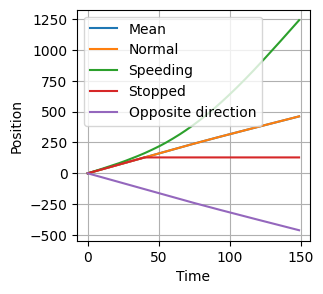

In [59]:
plt.figure(figsize=(3,3))


for i in range(test_traj_set.shape[0]):
    plt.plot(test_traj_set[i])

plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)

test_legend = ['Mean', 'Normal', 'Speeding', 'Stopped', 'Opposite direction']

plt.legend(test_legend)
plt.savefig('test_trajectories.pdf', bbox_inches='tight')

# Setting the variance of the measurement noise

First, we define info_e2 = $1/\sigma_\epsilon^2$, related to the measurement noise **that will generate the trajectories**

In [60]:
from scipy.stats import norm
info_e2 = 10 # this is the "generative noise", i.e., the amount of noise actually contaminated in the trajectory signal
info_e2_measurement = info_e2

# Adding Gaussian noise to the curve

In [61]:
for i in range(test_traj_set.shape[0]):
    test_traj_set[i,:] = test_traj_set[i,:] + norm.rvs(size=test_traj_set[i].shape) * np.sqrt(1./info_e2)


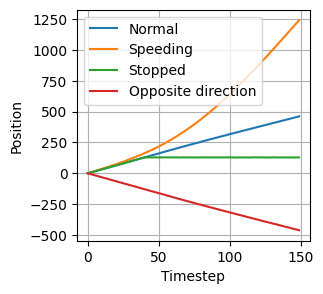

In [62]:
plt.figure(figsize=(3,3))
for i in range(1,test_traj_set.shape[0]):
    plt.plot(test_traj_set[i])

plt.xlabel('Timestep')
plt.ylabel('Position')
plt.grid(True)

plt.legend(test_legend[1:])
plt.savefig('test_traj_')

# Rebuilding curves from FPCA loads

In [63]:
# lambda_max_R = eig(y_pca_loads_R)[0][0]

This is a code for generation of a single trajectory from the PCA load of a_sample

## With noise

In [64]:
noise_samples = np.zeros((friendly_basis_rw2.shape[0],))
for i in range(friendly_basis_rw2.shape[0]):
    noise_samples[i] = norm.rvs() * np.sqrt(1./info_e2)

(array([ 1.,  1.,  1.,  2.,  1.,  0.,  2.,  0.,  2.,  6.,  4.,  2.,  2.,
         4.,  5.,  4.,  6.,  1.,  7.,  8., 10.,  9., 10.,  5.,  4.,  4.,
         4.,  4.,  4.,  5.,  4.,  3.,  3.,  5.,  3.,  4.,  1.,  0.,  1.,
         1.,  2.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.68632465, -0.65583568, -0.6253467 , -0.59485772, -0.56436874,
        -0.53387976, -0.50339078, -0.47290181, -0.44241283, -0.41192385,
        -0.38143487, -0.35094589, -0.32045692, -0.28996794, -0.25947896,
        -0.22898998, -0.198501  , -0.16801203, -0.13752305, -0.10703407,
        -0.07654509, -0.04605611, -0.01556714,  0.01492184,  0.04541082,
         0.0758998 ,  0.10638878,  0.13687775,  0.16736673,  0.19785571,
         0.22834469,  0.25883367,  0.28932264,  0.31981162,  0.3503006 ,
         0.38078958,  0.41127856,  0.44176753,  0.47225651,  0.50274549,
         0.53323447,  0.56372345,  0.59421243,  0.6247014 ,  0.65519038,
         0.68567936,  0.71616834,  0.74665732,  0.77714629,

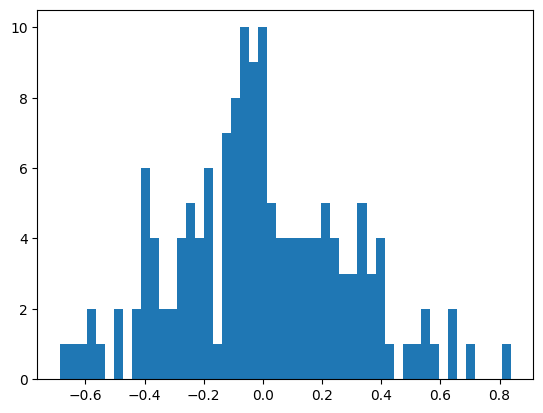

In [65]:
plt.hist(noise_samples, bins=50)

In [66]:
curvs = test_traj_set.copy()

In [67]:
# plt.figure(figsize=(7,2))
# # a_samples = [np.array([0,0]),y_pca_loads_R @ np.array([0.5,0]), y_pca_loads_R @ np.array([0,1]), y_pca_loads_R @ np.array([2,2])]
# # a_circle_samples = [np.array([0,0]), affine_coeffs_rw2[3,:], affine_coeffs_rw2[6,:], affine_coeffs_rw2[9,:]]
# a_circle_samples = [np.array([0,0]), np.array([3,3]), np.array([6,-9]), np.array([12,12])]
# a_samples = [y_pca_loads_R @ a for a in a_circle_samples]
# c_samples = [y_pca_loads_Q @ x for x in a_samples]
# # print(c_samples)
# # Generate a sample trajectory curve
# curvs = []
# for index, a_sample in enumerate(a_samples):
#     curv = np.zeros((friendly_basis_rw2.shape[0],))
#     for i in range(friendly_basis_rw2.shape[0]):
#         noise_samples_i = norm.rvs() * np.sqrt(1./info_e2)
#         curv[i] = friendly_basis_rw2[i].reshape((1,2)) @ a_sample.reshape((2,1)) + noise_samples_i * (lambda i: 0 if i == 0 else 1)(index)
#         # note the noise is already included: sigma_e * e where e~N(0,1)
#         # the first curve is without noise!
#     curv = curv + mean_curve2
#     curvs.append(curv)
#     # Plot the sample curve for reference
#     plt.plot(np.arange(friendly_basis_rw2.shape[0]), curv, label='Curve ' + str(index))
# plt.legend()
# plt.xlabel('Timestep')
# plt.ylabel('RW coordinate (ft)')
# plt.grid(True)

In [68]:
# curvs.append(container_y_new[3].copy()) # Curve 7 is a real trajectory from the dataset, Curve 6 is the approximated trajectory of Curve 7 with FPCA
# for i, curv in enumerate(curvs): 
#     plt.plot(curv, label='Curve {:d}'.format(i))
# plt.legend()

In [69]:
# # Visualize the difference between the test trajectories
# plt.subplot(2,2,1)
# plt.plot(np.arange(friendly_basis_rw2.shape[0])/10., curvs[2]-curvs[0])
# plt.title('0,1 curve and 0,0 curve')
# plt.subplot(2,2,2)
# plt.plot(np.arange(friendly_basis_rw2.shape[0])/10., curvs[1]-curvs[0])
# plt.title('0.5,0 curve and 0,0 curve')
# plt.subplot(2,2,3)
# plt.plot(np.arange(friendly_basis_rw2.shape[0])/10., curvs[3]-curvs[0])
# plt.title('2,2 curve and 0,0 curve')
# plt.subplot(2,2,4)
# plt.plot(np.arange(friendly_basis_rw2.shape[0])/10., curvs[4]-curvs[0])
# plt.title('-3,-2 curve and 0,0 curve')
# plt.tight_layout()

## Without noise

a_samples = [np.array([0,0]),y_pca_loads_R @ np.array([0.5,0]), y_pca_loads_R @ np.array([0,1]), y_pca_loads_R @ np.array([2,2])]
c_samples = [y_pca_loads_Q @ x for x in a_samples]
print(c_samples)
# Generate a sample trajectory curve
curvs = []
noise_samples = np.zeros((friendly_basis_rw2.shape[0],))
for index, a_sample in enumerate(a_samples):
    curv = np.zeros((friendly_basis_rw2.shape[0],))
    for i in range(friendly_basis_rw2.shape[0]):
        curv[i] = friendly_basis_rw2[i].reshape((1,2)) @ a_sample.reshape((2,1))
        # note the noise is already included: sigma_e * e where e~N(0,1)
        # the first curve is without noise!
    curv = curv + mean_curve2
    curvs.append(curv)
    # Plot the sample curve for reference
    plt.plot(np.arange(friendly_basis_rw2.shape[0])/10., curv, label='Curve ' + str(index))
plt.legend()

## Entropy curves generation

The entropy curves should be generated with a different model that conservatively estimate about the measurement noise

info_e2_detect is the amplifying coefficient to improve detection against noise. It is the coefficient to draw the marginal likelihood curves.

In [70]:
from scipy.stats import norm
info_e2_detect = 8 # this is the "detection noise" used to draw the marginal likelihood curves, it must be smaller than the generative noise - the amount of noise actually contaminated in the signal

An example of measurement noise added to the curve measurement

In [71]:
from otqd.otqd import OTQD

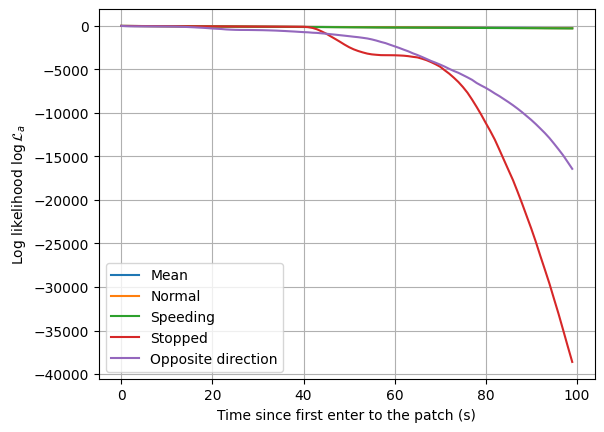

In [72]:
fix, ax = plt.subplots()
howlong=100
covar_sequence = np.zeros((howlong, 2, 2))
time_for_plot = np.arange(howlong)/10. # howlong seconds
mls = []

# For bayesian anomaly detector 
post_means = []
post_covars = []


for index, curve in enumerate(curvs):
    # curve = curv.copy() # use the curv which is the trajectory generated from a_sample defined above
    ml_with_time_d = np.zeros(curve.shape[0],)
    otqd = OTQD(info_a = np.linalg.inv(gm_rw2.covariances_) * 1.,mu_a = gm_rw2.means_.transpose(),info_e2 = info_e2_detect, pca_mean = mean_curve2,pca_components = friendly_basis_rw2, i_max=1)
    
    # Variables to store the posteriori mean and covariance for THIS SPECIFIC CURVE / TRAJECTORY
    post_mean_of_curve = []
    post_covar_of_curve = []

    for k in range(howlong): # should match time_for_plot
        otqd.new_measurement(curve[k])
        ml_log_likelihood, ml_covar = otqd.calculate_log_likelihood_with_covar()

        # For bayesian anomaly detection
        mu_prime, covar_prime = otqd.get_posteriori()
        post_mean_of_curve.append(mu_prime)
        post_covar_of_curve.append(covar_prime)

        where_ml_max = np.argmax(ml_log_likelihood)
        ml_with_time_d[k] = ml_log_likelihood[where_ml_max]
        covar_sequence[k,:,:] = ml_covar[where_ml_max,:,:]
    plt.plot(ml_with_time_d[0:howlong], label=test_legend[index]) # should also match time_for_plot
    mls.append(ml_with_time_d)

    # For Bayesian anomaly detector
    post_means.append(post_mean_of_curve)
    post_covars.append(post_covar_of_curve)
    
plt.xlabel('Time since first enter to the patch (s)')
plt.ylabel('Log likelihood $\log \mathcal{L}_a$')
plt.legend()
plt.grid(True)

Relative entropy curve related to **the standard curve** (corresponding to $\mu=0$)

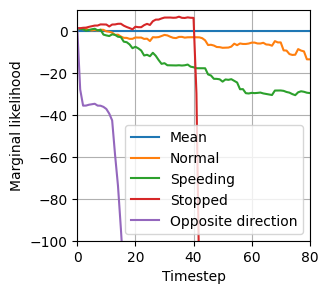

In [73]:
plt.figure(figsize=(3,3))

mlcs = []
for id, mlc in enumerate(mls):
    ml = mlc - mls[0]
    plt.plot(ml, label=test_legend[id])
    mlcs.append(ml)
plt.xlim((0,80))
plt.legend()

plt.ylim((-100, 10))

plt.xlabel('Timestep')
plt.ylabel('Marginal likelihood')
plt.grid()

plt.savefig('mls.pdf', bbox_inches='tight')

So these curves are fairly differentiable (compare with the no noise curves right below)

# Drawing the thresholding curves (without measurement noise)

These are the likelihood curves for **no measurement noise** (should approximate the immediately above graph). This presents the analytical formula to draw the curves directly from $a$, as an express way compared to creating a curve then run OTQD on this curve like above. 

This is best for understanding the individual terms and ensure the validity of the OTQD, as well as thresholding curve drawing. **Formula page 11**.

In [74]:
# for a in a_samples:
#     first_term = np.zeros((howlong,))
#     second_term = np.zeros((howlong,1,2))
#     second_term_h = np.zeros((howlong,))
#     all_terms = np.zeros((howlong,))
#     for i in range(howlong): 
#         fbi = friendly_basis_rw2[i].reshape((2,1))
#         first_term[i] = first_term[i-1] + info_e2 * np.square(fbi.T @ a)
#         second_term[i,:] = (second_term[i-1,:] + fbi.T * (fbi.T @ a)) # phi.T phi.T a
#         first_term_f = first_term[i].item()
#         second_term_f = -(info_e2**2) * second_term[i,:] @ covar_sequence[i,:,:] @ second_term[i,:].T
#         second_term_h[i] = second_term_f
#         all_terms[i] = -0.5 * (first_term_f + second_term_f)
#     plt.plot(all_terms)

The official draw the likelihood curve in case of no measurement noise

In [75]:
# sps = 0
# U = np.zeros((2,2))
# V = np.zeros((2,2))
# infs = np.zeros((2,2))
# l = np.zeros((80,))
# U_hist = np.zeros((80,2,2))
# V_hist = np.zeros((80,2,2))
# # info_e2 = 10 # use info_e2 from above (Visualizing Likelihood Curve)
# for i in range(80):
#     #print(i)
#     fbi = friendly_basis_rw2[i].reshape((2,1))
#     U += fbi @ fbi.T @ y_pca_loads_R
#     V += y_pca_loads_R.T @ fbi @ fbi.T @ y_pca_loads_R
#     infs += info_e2 * friendly_basis_rw2[i,:].reshape((2,1)) @ friendly_basis_rw2[i,:].reshape((1,2))
#     #scaled_sigma = .5 * info_e2 * (U.T @ np.linalg.inv(np.linalg.inv(gm_rw2.covariances_[0])*0.99 + infs) * info_e2 @ U - V)
#     scaled_sigma = (-U.T @ covar_sequence[i,:,:] * info_e2 @ U + V)
#     scaled_sigma_eigs, _ = eig(scaled_sigma)
#     # print(scaled_sigma_eigs)
#     #print(V @ V.T)
#     l[i] = -.5 * info_e2 * scaled_sigma_eigs[0]
#     #l[i] = lambda1_sigma * info_e2 * sps - 1
#     #l[i] =  2*info_e2*(lambda1_sigma * info_e2 * sps - 1) * ((lambda1_R ** 2) * sps)
#     # l[i] = lambda1_R ** 2 * sps
#     #print('---')
# plt.plot(l[0:])

## If the bound can be analytically predicted?

In [76]:
# # First perform the eigendecomposition of the sigma_m matrix
# eigs, Q = eig(np.linalg.inv(gm_rw2.covariances_[0]))
# L = np.diag(eigs)

In [77]:
# (.5) * y_pca_loads_R.T @ Q @ L @ Q.T @ y_pca_loads_R

Looks like it's correct :)

# Effects of measurement noise

In this section, we study how the measurement noise will make the threshold curve stochastic, and thus, hopefully we can estimate with a confidence level, whether the measurements have fallen outside of the acceptance region or not.

We "reversely build" the curve to check if the formulas are valid! This should match the relative entropy curves drawn above.

In [78]:
# ax1 = plt.subplot(2, 2, 1)
# ax3 = plt.subplot(2, 2, 3)
# ax4 = plt.subplot(2, 2, 4)
# for curve_no, cs in enumerate(a_circle_samples[1:]):
#     U = np.zeros((2,2))
#     V = np.zeros((2,2))
#     eps_phi = np.zeros((2,1))
#     espc = 0
#     llog = np.zeros((howlong,))
#     llog2 = np.zeros((howlong,))
#     llog3 = np.zeros((howlong,))
#     for i in range(howlong):
#         # print('---')
#         fbi = friendly_basis_rw2[i].reshape((2,1))
#         U += fbi @ fbi.T @ y_pca_loads_R
#         V += y_pca_loads_R.T @ fbi @ fbi.T @ y_pca_loads_R
#         scaled_sigma = -U.T @ covar_sequence[i,:,:] * info_e2 @ U + V
#         first_term = -cs.T @ scaled_sigma @ cs

#         eps = noise_samples[i]
#         eps_phi += eps * fbi
#         G = covar_sequence[i,:,:] * info_e2 @ U - y_pca_loads_R
#         second_term = 2 * eps_phi.T @ G @ cs

#         third_term = eps_phi.T @ covar_sequence[i,:,:] * info_e2 @ eps_phi

#         espc += np.square(eps)
#         fourth_term = espc

#         llog[i] = .5 * info_e2 * (first_term + second_term + third_term - fourth_term) # all terms present but noise are correlated
#         llog2[i] = .5 * info_e2 * (first_term + 0 + 0 - fourth_term) # removing second and third term
#         llog3[i] = .5 * info_e2 * (first_term + second_term + third_term - 0) # no chi-square term (should approx no noise case)
#         # llog[i] = eps
    
#     ax1.plot(llog, label = 'Curve ' + str(curve_no + 1))
#     ax3.plot(llog2, label = 'Curve ' + str(curve_no + 1))
#     ax4.plot(llog3, label = 'Curve ' + str(curve_no + 1))
#     # plt.plot(mls[curve_no] - mls[0])
# ax1.set_title('All terms + noise')
# ax3.set_title('Approx + noise')
# ax4.set_title('No noise')
# ax1.set_xlim((0,80))
# ax3.set_xlim((0,80))

# ax1.legend()

# plt.subplot(2, 2, 2)
# for curve_no, cs in enumerate(a_circle_samples[1:]):
#     plt.plot(mls[curve_no+1] - mls[0], label = 'Curve ' + str(curve_no + 1))
# plt.xlim((0,80))
# plt.title('OTQD curves')
# plt.legend()
# plt.tight_layout()

This figure is very important! The first and second (top) figures show that the effect of the noise is too large as it can shuffle the order of the curves, and the detection signal (fourth figure) is buried inside the noise (as OTQD is at least 10 times higher than this).

Let's visualize the margin added when bounding in this fashion:

In [79]:
# plt.plot(llog - (mls[-1] - mls[0])[:100])

So the reconstruction is almost exact! The variation is due to the noise of the last curve is being reused to generate the first, second and third curves, so they are not precisely. But the close-to-zero variation should indicate this is acceptable.

**For sequential bounding of each individual terms on page 22, see the file thresholding_curve3.ipynb**

In [80]:
from scipy.stats import chi2

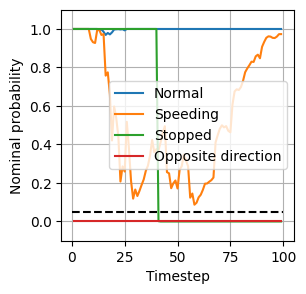

In [81]:
# cs = np.array([0.5,0]).reshape((2,1))

plt.figure(figsize=(3,3))
detection_threshold_distance = 1 # already squared

for curve_no in range(1,test_traj_set.shape[0]):
# for curve_no in [2]: # 0: mean, 1: normal, 2: speeding, 3: stopped, 4: wrong-way driving
    # cs = cs.reshape((2,1))
    U = np.zeros((2,2))
    V = np.zeros((2,2))
    eps_phi = np.zeros((2,1))
    espc = 0
    llh_curve = mls[curve_no] - mls[0] # OTQD curves
    llog = np.zeros((howlong,))
    y_log = np.zeros((howlong,))
    z_log = np.zeros((howlong,))
    for i in range(howlong):
        # print('---')
        fbi = friendly_basis_rw2[i].reshape((2,1))
        U += fbi @ fbi.T @ y_pca_loads_R
        V += y_pca_loads_R.T @ fbi @ fbi.T @ y_pca_loads_R
        scaled_sigma = -U.T @ covar_sequence[i,:,:] * info_e2_detect @ U + V
        first_term = -eig(scaled_sigma)[0][0] * detection_threshold_distance

        #z = -info_e2 * first_term - 2 * llh_curve[i]
        # z = info_e2 * first_term - 2 * llh_curve[i]
        y = info_e2 * first_term
        y_log[i] = y 

        z = info_e2 * first_term - 2 * info_e2 / info_e2_detect * llh_curve[i]
        z_log[i] = z
        # print(info_e2_measurement * first_term - 2 * llh_curve[i], i)
        # print(-info_e2_measurement * first_term - 2 * info_e2_measurement / info_e2 * llh_curve[i], i)
        # print('z', z,i)
        cdf_score = 1 - chi2.cdf(z,i)
        # print(z, cdf_score)
        llog[i] = cdf_score

        # llog[i] = .5 * info_e2 * (first_term + second_term + third_term - fourth_term)
        # llog[i] = eps
    # plt.plot(llog, label="Curve " + str(curve_no + 1))
    # plt.plot(y_log)
    plt.plot(llog, label=test_legend[curve_no])
plt.legend()
plt.ylim((-0.1,1.1))

# draw a horizontal line at 0.05
plt.plot([0,howlong],[0.05,0.05], 'k--')
plt.xlabel('Timestep')
plt.ylabel('Nominal probability')
plt.grid()

plt.savefig('nominal_pdf.pdf', bbox_inches='tight')

# Local Outlier Factor (LOF)

In [82]:
y_set = np.array(container_y_new)
np.save('anomaly_paper_y_set.npy', y_set) # save to a numpy file

In [83]:
np.save('anomaly_paper_test_traj_set.npy', test_traj_set) # save to a numpy file

In [84]:
y_set.shape

(200, 150)

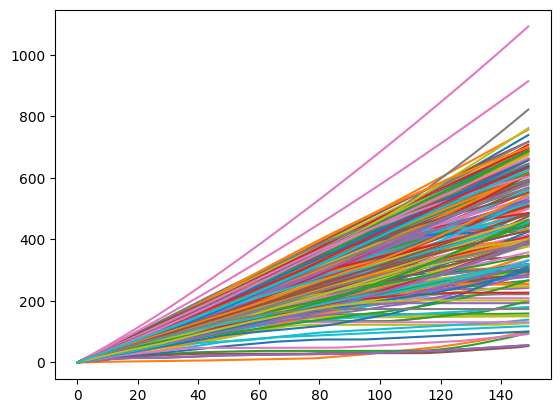

In [85]:
for i in range(y_set.shape[0]):
    plt.plot(y_set[i,:])


In [86]:
# To test a trajectory, we concatenate the test trajectory with the training trajectories

y_set_augmented = np.concatenate((test_traj_set, y_set), axis=0)
print('The first {} trajectories are test trajectories'.format(test_traj_set.shape[0]))

The first 5 trajectories are test trajectories


In [87]:
from sklearn.neighbors import LocalOutlierFactor

neigh = LocalOutlierFactor(n_neighbors=5)
neigh.fit(y_set_augmented)

LocalOutlierFactor(n_neighbors=5)

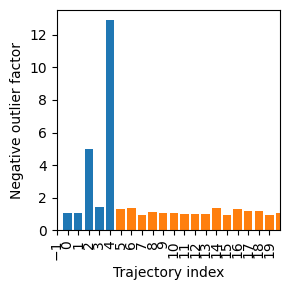

In [88]:
# bar plot of the negative outlier factor

plt.figure(figsize=(3,3))

plt.bar(np.arange(test_traj_set.shape[0]), -neigh.negative_outlier_factor_[:test_traj_set.shape[0]])
plt.bar(np.arange(test_traj_set.shape[0], y_set_augmented.shape[0], 1), -neigh.negative_outlier_factor_[test_traj_set.shape[0]:])

plt.xlim((-1,20))
plt.xticks(np.arange(-1, 20, 1))
# rotate the xticks
plt.xticks(rotation=90)
plt.xlabel('Trajectory index')
plt.ylabel('Negative outlier factor')
# plt.grid()

plt.tight_layout()
plt.savefig('lof_3_entire.pdf', bbox_inches = 'tight')


Now we compute the LOF at various timesteps

In [89]:
percentile_rank_across_t = []

for t_lim in range(20,y_set_augmented.shape[1]-1):
    neigh = LocalOutlierFactor(n_neighbors=5) # modify n_neighbors here
    y_set_augmented_t = y_set_augmented[:,:t_lim]
    neigh.fit(y_set_augmented_t)
    lof = -neigh.negative_outlier_factor_
    # Compute the percentile rank of the test trajectories
    percentile_rank = np.zeros((test_traj_set.shape[0],))
    for i in range(test_traj_set.shape[0]):
        percentile_rank[i] = np.sum(lof[i] > lof[test_traj_set.shape[0]:]) / lof[test_traj_set.shape[0]:].shape[0]
    
    percentile_rank_across_t.append(percentile_rank)

percentile_rank_across_t = np.array(percentile_rank_across_t)


In [90]:
percentile_rank_across_t.shape

(129, 5)

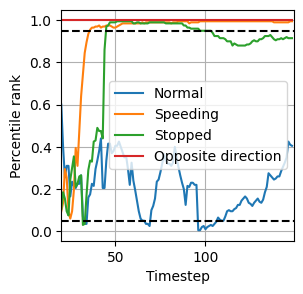

In [91]:
plt.figure(figsize=(3,3))
# plt.plot(np.arange(20, y_set_augmented.shape[1]-1), percentile_rank_across_t[:,0], label=test_legend[0])
plt.plot(np.arange(20, y_set_augmented.shape[1]-1), percentile_rank_across_t[:,1], label=test_legend[1])
plt.plot(np.arange(20, y_set_augmented.shape[1]-1), percentile_rank_across_t[:,2], label=test_legend[2])
plt.plot(np.arange(20, y_set_augmented.shape[1]-1), percentile_rank_across_t[:,3], label=test_legend[3])
plt.plot(np.arange(20, y_set_augmented.shape[1]-1), percentile_rank_across_t[:,4], label=test_legend[4])

plt.xlim((20, y_set_augmented.shape[1]-1))

plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Percentile rank')

# draw horizontal lines at 0.05 and 0.95
plt.plot([20,y_set_augmented.shape[1]-1],[0.05,0.05], 'k--')
plt.plot([20,y_set_augmented.shape[1]-1],[0.95,0.95], 'k--')

plt.grid()
plt.savefig('lof_3.pdf', bbox_inches = 'tight')

# =======================================
# Bayesian Anomaly Detection

In [92]:
Sigma_a_mat = gm_rw2.covariances_[0,:,:]
Q_mat = np.linalg.inv(scipy.linalg.sqrtm(Sigma_a_mat))


In [93]:
p_nominals = []

for curve_no in range(test_traj_set.shape[0]):
# for curve_no in [4]:
    p_nominal = np.zeros((howlong,))

    mu_p_nominal = np.zeros((howlong,))
    var_p_nominal = np.zeros((howlong,))

    for i in range(howlong):
        # 0: mean, 1: normal, 2: speeding, 3: stopped, 4: wrong-way driving
        mu_a_star = post_means[curve_no][i].reshape((-1,1)) # posteriori mean
        cov_a_star = post_covars[curve_no][i] # posteriori covar

        Q_star_mat = scipy.linalg.sqrtm(Q_mat @ cov_a_star @ Q_mat.T)

        mu_of_cdf = mu_a_star.T @ Q_mat.T @ Q_mat @ mu_a_star
        cov_of_cdf = 4 * (mu_a_star.T @ Q_mat.T @ Q_star_mat @ Q_star_mat.T @ Q_mat @ mu_a_star)

        mu_p_nominal[i] = mu_of_cdf.item()
        var_p_nominal[i] = cov_of_cdf.item()

        p_nominal[i] = norm.cdf(1.0, mu_of_cdf, cov_of_cdf) # 1 here is the detection threshold
    p_nominals.append(p_nominal)


In [94]:
p_nominals = np.array(p_nominals)

In [95]:
# plt.plot(mu_p_nominal)
# plt.title('Mean of the nominal probability')

# plt.figure()
# plt.plot(var_p_nominal)
# plt.title('Variance of the nominal probability')

In [96]:
# plt.plot(p_nominal)

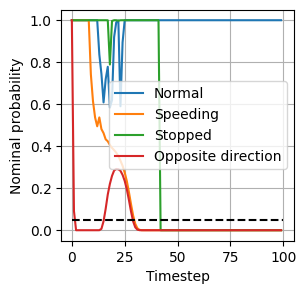

In [97]:
plt.figure(figsize=(3,3))

for i in range(1,p_nominals.shape[0]):
    plt.plot(p_nominals[i,:], label=test_legend[i])

# draw a horizontal line at 0.05
plt.plot([0,howlong],[0.05,0.05], 'k--')

plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Nominal probability')
plt.grid()

plt.savefig('nominal_prob_4.pdf', bbox_inches = 'tight')